## This notebook is for Linear stability analysis of the circuit, and uses the search result from parameter search in the preliminary analysis. In the previous one, $b_i$, $V_i$, $\mu_i$, $K_{Ai}$, $K_{Bi}$ and $K_{Ci}$ are taken the same. 

![Circute 3954](3954.png "Circute 3954")

## Here, we extend the search by starting from these points.

In [3]:
%config Completer.use_jedi = False
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Latex

from itertools import product
from scipy.optimize import fsolve
from scipy.linalg import eigvals

from tqdm import tqdm

import sys
sys.path.append("/end/home/rh2310/morpho_repo/amplitude_method")
from utils import *

sys.path.append("/end/home/rh2310/morpho_repo")
from local_utils import *

from turing.three_nodes_circuits import create_circuit_3954

In [4]:
init_printing(use_latex='mathjax')#(use_latex=True)

#### Define a list of parameters

In [5]:
A, B, C = symbols('A, B, C', real=True, positive = True)

D_A, D_B = symbols('D_A, D_B', real=True, positive = True)

(b_A, b_B, b_C,
 V_A, V_B, V_C,
K_AA, K_AB, K_AC, K_BA, K_BC, K_CB, K_CC,
μ_A, μ_B, μ_C) = symbols(
    'b_A, b_B, b_C, V_A, V_B, V_C, K_AA, K_AB, K_AC, K_BA, K_BC, K_CB, K_CC, mu_A, mu_B, mu_C', 
    real=True, positive = True)

k, n = symbols('k, n', integer=True)

> The PDEs are as follows

<h3><center>$
     \frac{\partial A}{\partial t} = b_A  +   V_A  \frac{1}{1+\left(\frac{K_{AA}}{A }\right)^{n}} \frac{1}{1+\left(\frac{B}{K_{BA} }\right)^{n}} -  \mu_A A + D_A \nabla^2 A,
$</center></h3>

<h3><center>$     \frac{\partial B}{\partial t} = b_B  +   V_B  \frac{1}{1+\left(\frac{K_{AB}}{A }\right)^{n}} \frac{1}{1+\left(\frac{C}{K_{CB} }\right)^{n}} -  \mu_B B + D_B \nabla^2 B,
$</center></h3>

<h3><center>$
\frac{\partial C}{\partial t} = b_C  +   V_C  \frac{1}{1+\left(\frac{A}{K_{AC} }\right)^{n}} \frac{1}{1+\left(\frac{B}{K_{BC} }\right)^{n}} \frac{1}{1+\left(\frac{K_{CC}}{C }\right)^{n}} -  \mu_C C,
$</center></h3>

![Circute 3954](3954.png "Circute 3954")

Then, we define kinetic terms as

<h3><center>$f_A(A, B, C) = b_A  +   V_A  \frac{1}{1+\left(\frac{K_{AA}}{A }\right)^{n}} \frac{1}{1+\left(\frac{B}{K_{BA} }\right)^{n}} -  \mu_A A$</center></h3>
<h3><center>$f_B(A, B, C) = b_B  +   V_B  \frac{1}{1+\left(\frac{K_{AB}}{A }\right)^{n}} \frac{1}{1+\left(\frac{C}{K_{CB} }\right)^{n}} -  \mu_B B$</center></h3>
<h3><center>$f_C(A, B, C) = b_C  +   V_C  \frac{1}{1+\left(\frac{A}{K_{AC} }\right)^{n}} \frac{1}{1+\left(\frac{B}{K_{BC} }\right)^{n}} \frac{1}{1+\left(\frac{K_{CC}}{C }\right)^{n}} -  \mu_C C$</center></h3>


In [6]:
def act(x, K, n):
    return 1/(1 + (K/x)**n)

def inh(x, K, n):
    return 1/(1 + (x/K)**n)


fA = b_A + V_A*act(A, K_AA, n)*inh(B, K_BA, n) - μ_A * A
fB = b_B + V_B*act(A, K_AB, n)*inh(C, K_CB, n) - μ_B * B
fC = b_C + V_C*inh(A, K_AC, n)*inh(B, K_BC, n)*act(C, K_CC, n) - μ_C * C

lprint(r"$f_A(A, B, C) =$ {0}", fA)
lprint(r"$f_B(A, B, C) =$ {0}", fB)
lprint(r"$f_C(A, B, C) =$ {0}", fC)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

#### which as a vector, we can define it like

In [7]:
Kinetic = Matrix([[fA], [fB], [fC]])
lprint(r"$\boldsymbol{f}(A, B, C) =$ {0} ", Kinetic)

<IPython.core.display.Latex object>

# Load the parameters that we found for the following assumptions:
> <center>$     b_A = b_B = b_C, $</center>
> <center>$     V_A = V_B = V_C, $</center>
> <center>$     \mu_A = \mu_B = \mu_C, $</center>
> <center>$     K_{AA} = K_{AB} = K_{AC}, $</center>
> <center>$     K_{BA} = K_{BC}, $</center>
> <center>$     K_{CB} = K_{CC}. $</center>

In [356]:
with open('turing_parameters_same_b_v_mu.npy', 'rb') as f:
    turing_parameters_pre = np.load(f)

# Case 1

> create a combination of parameters $(\theta_A, \theta_B, \theta_C)$, such that each $\theta_i$ is selected from the load dataset.

In [357]:
from itertools import combinations, permutations
params = []
for theta_A, theta_B, theta_C in permutations(turing_parameters_pre, 3):
    (n_val, b_A_val, mu_A_val, V_A_val, K_AA_val,_, _) = theta_A
    n_val = int(n_val)
    (_, b_B_val, mu_B_val, V_B_val, K_AB_val, K_BA_val, K_CB_val) = theta_B
    (_, b_C_val, mu_C_val, V_C_val, K_AC_val,K_BC_val, K_CC_val) = theta_C
    params.append(
        (n_val, 
         b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
         b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
         b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val))
    
    

In [358]:
params = np.array(params)

In [417]:
2*np.pi*64

402.1238596594935

In [504]:
params.shape

(114790770, 17)

#### First, we find the fix points of the system without diffusion. 


The solution of the above system finds $A^*, B^*, C^*$ such that
<center>$f_A(A^*, B^*, C^*) = 0$</center>
<center>$f_B(A^*, B^*, C^*) = 0$</center>
<center>$f_C(A^*, B^*, C^*) = 0$</center>

In [8]:
f1 = lambdify([n, b_A, μ_A, V_A, K_AA, K_AB, K_AC,
               b_B, μ_B, V_B, K_BA, K_BC,
               b_C, μ_C, V_C, K_CB, K_CC,
               A,B,C], 
               fA,
              modules='numpy')

f2 = lambdify([n, b_A, μ_A, V_A, K_AA, K_AB, K_AC,
               b_B, μ_B, V_B, K_BA, K_BC,
               b_C, μ_C, V_C, K_CB, K_CC,
               A,B,C], 
              fB,
              modules='numpy')

f3 = lambdify([n, b_A, μ_A, V_A, K_AA, K_AB, K_AC,
               b_B, μ_B, V_B, K_BA, K_BC,
               b_C, μ_C, V_C, K_CB, K_CC,
               A,B,C], 
               fC,
              modules='numpy')

def create_func(n, b_A, μ_A, V_A, K_AA, K_AB, K_AC,
               b_B, μ_B, V_B, K_BA, K_BC,
               b_C, μ_C, V_C, K_CB, K_CC):
    def f_1(args):
        A,B,C = args
        return (f1(n, b_A, μ_A, V_A, K_AA, K_AB, K_AC,
                   b_B, μ_B, V_B, K_BA, K_BC,
                   b_C, μ_C, V_C, K_CB, K_CC, A,B,C),
                f2(n, b_A, μ_A, V_A, K_AA, K_AB, K_AC,
                   b_B, μ_B, V_B, K_BA, K_BC,
                   b_C, μ_C, V_C, K_CB, K_CC, A,B,C),
                f3(n, b_A, μ_A, V_A, K_AA, K_AB, K_AC,
                   b_B, μ_B, V_B, K_BA, K_BC,
                   b_C, μ_C, V_C, K_CB, K_CC, A,B,C)) 
    
    return f_1

#### Next, to linearise the PDE system, we find the Jacobian of $(f_A, f_B, f_C)$ 

In [9]:
J_jac = Kinetic.jacobian([A, B, C])
hprint(r"J= \frac{\partial \boldsymbol{f}_i}{\partial u_j} = ", J_jac)
J_jac_func = lambdify([n, b_A, μ_A, V_A, K_AA, K_AB, K_AC,
                       b_B, μ_B, V_B, K_BA, K_BC,
                       b_C, μ_C, V_C, K_CB, K_CC, A,B,C], 
                       J_jac,
              modules='numpy')

<IPython.core.display.Latex object>

In [365]:
def single_proccess(args):    
    index, params = args
    
    def find_roots(n_val, b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                   b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                   b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val,
                   verbose=False):    
        func = create_func(n_val, b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                           b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                           b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val)
        #
        roots_res = []
        for init_vals in product([.1,-.1], repeat=3):        
            roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
            (a_1, b_1, c_1) = func(roots)
            if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7 and c_1 < 1e-7:
                roots_res.append(roots)
                return roots_res
        for init_vals in product([1,-1], repeat=3):        
            roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
            (a_1, b_1, c_1) = func(roots)
            if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7 and c_1 < 1e-7:
                roots_res.append(roots)
                return roots_res

        for init_vals in product([10,-10], repeat=3):        
            roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
            (a_1, b_1, c_1) = func(roots)
            if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7 and c_1 < 1e-7:
                roots_res.append(roots)
                return roots_res

        for init_vals in product([100,-100], repeat=3):        
            roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
            (a_1, b_1, c_1) = func(roots)
            if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7 and c_1 < 1e-7:
                roots_res.append(roots)
                return roots_res

        if len(roots_res) == 0:
            if verbose:
                print(msg)
                print("roots:", roots)
                print("values", a_1, b_1, c_1)
            return roots_res 
        else:
            roots_res2 = [roots_res[0]]
            for item in roots_res[1:]:
                if np.any(item < 0):
                    continue
                if not np.any([np.isclose(item2, item) for item2 in roots_res2]):
                    roots_res2.append(item)
            return roots_res2 
    
    count_unstable = 0
    count_unstable_g = 0
    count_unstable_inf_k = 0
    count_unstable_inf_k_g = 0
    count_supper_stable = 0
    failed_roots = 0


    valid_roots = []
    valid_parameters = []
    valid_jacobians = []
    valid_eigenvals = []
    valid_k_max = []
    
    
    D_A_val = 0.01
    D_B_val = 1.0

    for i  in range(len(params)):
        (n_val, 
         b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
         b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
         b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = params[i, :]    
        #
        roots_all = find_roots(n_val, b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                               b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                               b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val)
        # check the solution is valid    
        if len(roots_all) == 0:
            continue
        else:
            for roots in roots_all:
                J_test = J_jac_func(n_val, b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                                    b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                                    b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val,
                                    A = roots[0], B = roots[1], C = roots[2])
                
                    
                s1 = np.abs(J_test[0, 1]) + np.abs(J_test[0, 2])
                s2 = np.abs(J_test[1, 0]) + np.abs(J_test[1, 2])
                s3 = np.abs(J_test[2, 0]) + np.abs(J_test[2, 1])

                r1 = J_test[0, 0] + s1
                r2 = J_test[1, 1] + s2
                r3 = J_test[2, 2] + s3       
                l1 = J_test[0, 0] - s1
                l2 = J_test[1, 1] - s2
                l3 = J_test[2, 2] - s3        



                if l1 > 0 and l2 > 0 and l3 >0 :
                    count_unstable_g += 1
                    continue

                if r1 < 0 and r2 <0 and r3<0:
                    count_supper_stable += 1
                    continue
                # Check the third nodes left lower bound, if it is positive, after
                # k_max, the one eigenvalues remain positive for all k > k_max    
                if l3 > 0:
                    count_unstable_inf_k_g += 1
                    continue


                eigen_vals = eigvals(J_test)

                if np.any(np.real(eigen_vals > 0)):
                    count_unstable += 1
                    continue
        
                # Find k_max and check to see if the eigenvalues remain positive
                # after pasing the k_max
                k2_1_D_A = s1+J_test[0,0]# if J_test[0,0] <= 0 else s1+J_test[0,0]
                k2_2_D_B = s2+J_test[1,1]# if J_test[1,1] <= 0 else s2+J_test[1,1]
                # Include the third disk
                third_disk = min(J_test[2, 2] - s3, 0)
                #
                k2_1_D_A = k2_1_D_A - third_disk
                k2_2_D_B = k2_2_D_B - third_disk

                k2_1 = k2_1_D_A/D_A_val
                k2_2 = k2_2_D_B/D_B_val

                k_2_max = max(k2_1, k2_2)

                J_test2 = J_test.copy()
                J_test2[0,0] -= (k_2_max+10)*D_A_val
                J_test2[1,1] -= (k_2_max+10)*D_B_val

                eigen_vals2 = eigvals(J_test2)

                if np.any(np.real(eigen_vals2 > 0)):
                    count_unstable_inf_k += 1
                    continue
                if J_test2[2,2] > 0:
                    count_unstable_inf_k += 1
                    continue

                valid_roots.append(roots)
                valid_parameters.append((n_val, b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                                         b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                                         b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val))
                valid_jacobians.append(J_test)
                valid_eigenvals.append(eigen_vals) 
                valid_k_max.append(k_2_max)
                
    with open(f"./temp/temp_parameters_round_1_index_{index}.npy", 'wb') as f:
        np.save(f, (count_unstable,
                    count_unstable_g,
                    count_unstable_inf_k,
                    count_unstable_inf_k_g,
                    count_supper_stable,
                    failed_roots,
                    valid_roots,
                    valid_parameters,
                    valid_jacobians,
                    valid_eigenvals,
                    valid_k_max))
    return index
    

In [ ]:
from multiprocessing import Pool
num_process = 55
part_len = 2087105#2295816#2087105
#indices = [(i*part_len, (i+1)*part_len-1) for i in range(num_process)]
#params_list = [params[i:j,:]  for i,j in indices]
args_list = [(i, params[i*part_len:(i+1)*part_len-1, :])  for i in range(num_process)]

In [367]:
with Pool(num_process) as p:
    res = p.map(single_proccess, args_list)

In [23]:
def load_and_conc(num_process):
    count_unstable = 0
    count_unstable_g = 0
    count_unstable_inf_k = 0
    count_unstable_inf_k_g = 0
    count_supper_stable = 0
    failed_roots = 0


    valid_roots = None
    valid_parameters = None
    valid_jacobians = None
    valid_eigenvals = None
    valid_k_max = None
    
    
    for index in range(num_process):
        with open(f"./temp/temp_parameters_round_1_index_{index}.npy", 'rb') as f:
            (count_unstable_i,
            count_unstable_g_i,
            count_unstable_inf_k_i,
            count_unstable_inf_k_g_i,
            count_supper_stable_i,
            failed_roots_i,
            valid_roots_i,
            valid_parameters_i,
            valid_jacobians_i,
            valid_eigenvals_i,
            valid_k_max_i) = np.load(f, allow_pickle=True)
        
        count_unstable += count_unstable_i
        count_unstable_g += count_unstable_g_i
        count_unstable_inf_k += count_unstable_inf_k_i
        count_unstable_inf_k_g += count_unstable_inf_k_g_i
        count_supper_stable += count_supper_stable_i
        failed_roots += failed_roots_i

        if valid_roots is None:
            valid_roots =  valid_roots_i
            valid_parameters = valid_parameters_i
            valid_jacobians =  valid_jacobians_i
            valid_eigenvals =  valid_eigenvals_i
            valid_k_max = valid_k_max_i
        else:
            valid_roots = np.concatenate([valid_roots, valid_roots_i])
            valid_parameters = np.concatenate([valid_parameters, valid_parameters_i])
            valid_jacobians = np.concatenate([valid_jacobians, valid_jacobians_i])
            valid_eigenvals = np.concatenate([valid_eigenvals, valid_eigenvals_i])
            valid_k_max = np.concatenate([valid_k_max, valid_k_max_i])
            
    return (count_unstable,
            count_unstable_g,
            count_unstable_inf_k,
            count_unstable_inf_k_g,
            count_supper_stable,
            failed_roots,
            valid_roots,
            valid_parameters,
            valid_jacobians,
            valid_eigenvals,
            valid_k_max) 

In [27]:
(count_unstable,
count_unstable_g,
count_unstable_inf_k,
count_unstable_inf_k_g,
count_supper_stable,
failed_roots,
valid_roots,
valid_parameters,
valid_jacobians,
valid_eigenvals,
valid_k_max) = load_and_conc(num_process)

In [28]:
failed_roots

0

In [29]:
total = part_len*num_process#
print(f"Of total {total} parameters :")
print("Original:",count_unstable, f" {100*count_unstable/total:.2f}%")
print("Unstable Gershgoring:",count_unstable_g, f" {100*count_unstable_g/total:.2f}%")
print("Supper stable Gershgoring:",count_supper_stable, f" {100*count_supper_stable/total:.2f}%")
print("Infinite K Gershgoring:",count_unstable_inf_k_g, f" {100*count_unstable_inf_k_g/total:.2f}%")
print("Infinite K eigen:",count_unstable_inf_k, f" {100*count_unstable_inf_k/total:.2f}%")
print("--")
print("Original leftovers:",total-count_unstable)
print("Unstable G leftovers:",total-count_unstable_g)
print("Supper stable leftovers:",total-count_supper_stable)
print("Infinite K G leftovers:",total-count_unstable_inf_k_g)
print("Infinite K eigen leftovers:",total-count_unstable_inf_k)
print("Total leftovers:",len(valid_parameters))

Of total 114790775 parameters :
Original: 10113132  8.81%
Unstable Gershgoring: 0  0.00%
Supper stable Gershgoring: 48927683  42.62%
Infinite K Gershgoring: 1145798  1.00%
Infinite K eigen: 26778  0.02%
--
Original leftovers: 104677643
Unstable G leftovers: 114790775
Supper stable leftovers: 65863092
Infinite K G leftovers: 113644977
Infinite K eigen leftovers: 114763997
Total leftovers: 51104279


## Including the diffusion

In [10]:
J_jac_diff = J_jac - Matrix([[D_A*k**2, 0,        0], 
                             [0,        D_B*k**2, 0],
                             [0,        0,        0],
                           ])
hprint(r"J_{diff}= ", J_jac_diff)

J_jac_diff_func = lambdify([n, b_A, μ_A, V_A, K_AA, K_AB, K_AC,
                            b_B, μ_B, V_B, K_BA, K_BC,
                            b_C, μ_C, V_C, K_CB, K_CC, A,B,C], 
               J_jac_diff,
              modules='numpy')

<IPython.core.display.Latex object>

In [31]:
import warnings
warnings.filterwarnings("ignore")

def single_proccess2(args):
    valid_parameters, valid_roots, k_2_maxs = args
    D_A_val=.01
    D_B_val=1

    turing_dispersions_1 = []
    turing_dispersions_2 = []
    turing_dispersions_3 = []
    turing_parameters = []
    turing_k_max = []
    

    def check_type(item):
        return not isinstance(item, float) and not isinstance(item, int)

    for i  in range(len(valid_parameters)):

        (n_val, b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
         b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
         b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = valid_parameters[i]    

        #indices.append(i)
        λ_1, λ_2, λ_3 = list(J_jac_diff.subs(
                              {n:n_val, 
                               b_A:b_A_val, 
                               μ_A:mu_A_val, 
                               V_A:V_A_val,
                               K_AA:K_AA_val, 
                               K_AB:K_AB_val,  
                               K_AC:K_AC_val,
                               b_B:b_B_val, 
                               μ_B:mu_B_val, 
                               V_B:V_B_val,
                               K_BA:K_BA_val, 
                               K_BC:K_BC_val,  
                               b_C:b_C_val, 
                               μ_C:mu_C_val, 
                               V_C:V_C_val,
                               K_CB:K_CB_val, 
                               K_CC:K_CC_val,  
                               D_A: D_A_val , 
                               D_B: D_B_val,
                               A:valid_roots[i][0], 
                               B:valid_roots[i][1], 
                               C:valid_roots[i][2]}
                         ).eigenvals().keys())

        λ_1_func = lambdify([k], 
                             λ_1,
                             modules='numpy')
        λ_2_func = lambdify([k], 
                             λ_2,
                             modules='numpy')
        λ_3_func = lambdify([k], 
                             λ_3,
                             modules='numpy')
        k_max = np.sqrt(k_2_maxs[i])
        ks = np.linspace(0, k_max + 1, 10000).astype(np.complex64) 
        dis1 = λ_1_func(ks)
        if check_type(dis1):
            dis1[np.isinf(np.real(dis1))] = -100

        dis2 = λ_2_func(ks)
        if check_type(dis2):
            dis2[np.isinf(np.real(dis2))] = -100

        dis3 = λ_3_func(ks)
        if check_type(dis2):
            dis3[np.isinf(np.real(dis3))] = -100
        #
        if check_type(dis1) and np.count_nonzero(np.real(dis1) > 0) > 1 and np.real(dis1)[-1] <= 0:
            #turing_parameters_index.append(i)
            turing_dispersions_1.append(dis1)
            turing_dispersions_2.append(dis2)
            turing_dispersions_3.append(dis3)
            turing_parameters.append(valid_parameters[i])
            turing_k_max.append(k_max)
        elif check_type(dis2) and np.count_nonzero(np.real(dis2) > 0) > 1  and np.real(dis2)[-1] <= 0:
            #turing_parameters_index.append(i)
            turing_dispersions_1.append(dis1)
            turing_dispersions_2.append(dis2)
            turing_dispersions_3.append(dis3)
            turing_parameters.append(valid_parameters[i])
            turing_k_max.append(k_max)
        elif check_type(dis3) and np.count_nonzero(np.real(dis3) > 0) > 1  and np.real(dis3)[-1] <= 0:
            #turing_parameters_index.append(i)
            turing_dispersions_1.append(dis1)
            turing_dispersions_2.append(dis2)
            turing_dispersions_3.append(dis3)
            turing_parameters.append(valid_parameters[i])
            turing_k_max.append(k_max)
    return (turing_dispersions_1,
            turing_dispersions_2,
            turing_dispersions_3,
            turing_parameters,
            turing_k_max)

In [32]:
len(valid_roots)

51104279

In [35]:
num_process = 55
part_len = 10000#929740
start = 0
steps = 90
indices = [(start + i*part_len*steps, start + (i+1)*part_len*steps-1) for i in range(num_process)]
#valid_parameters_list = [valid_parameters[i:j,:]  for i,j in indices]
#valid_roots_list = [valid_roots[i:j,:]  for i,j in indices]
args_list = [(valid_parameters[i:j:steps,:], valid_roots[i:j:steps,:], valid_k_max[i:j:steps])  
             for i,j in indices]

In [36]:
indices[-1]

(48600000, 49499999)

In [37]:
with Pool(num_process) as p:
    res2 = p.map(single_proccess2, args_list)

In [38]:
ks = np.linspace(0,10, 10000).astype(np.complex64)
for i in range(len(res2)):
    for j in range(len(res2[i][0])):
        if isinstance(res2[i][0][j], int) or isinstance(res2[i][0][j], float):
            res2[i][0][j] = np.zeros_like(ks)

In [39]:
turing_dispersions_1 = np.concatenate([res2[i][0] for i in range(len(res2)) if len(res2[i][0]) > 0 ])
turing_dispersions_2 = np.concatenate([res2[i][1] for i in range(len(res2)) if len(res2[i][1]) > 0 ])
turing_dispersions_3 = np.concatenate([res2[i][2] for i in range(len(res2)) if len(res2[i][2]) > 0 ])
turing_parameters = np.concatenate([res2[i][3] for i in range(len(res2))  if len(res2[i][3]) > 0])
turing_k_max = np.concatenate([res2[i][4] for i in range(len(res2))  if len(res2[i][4]) > 0])

In [40]:
len(turing_parameters)

87001

In [41]:
#with open('turing_parameters_set_2.npy', 'wb') as f:
#    np.save(f, turing_parameters)
with open('turing_parameters_set_2.npy', 'rb') as f:
    turing_parameters = np.load(f)


# Select the subset that is Turing or Hopf

In [11]:
# Combine three arrays to construct continuous curves
def combine(d1, d2, d3, deltaX):
    dc1 = np.zeros_like(d1)
    dc2 = np.zeros_like(d2)
    dc3 = np.zeros_like(d3)
    
    def distance(y1, y2):
        return (np.real(y1) - np.real(y2))**2 + deltaX**2
    def get_three(i):
        return (d1[i], d2[i], d3[i])                    
        
    # init
    dc1[0], dc2[0], dc3[0] = get_three(0)
    # next closest
    next_i = get_three(1) 
    #print(dc1[0], dc2[0], dc3[0])
    #print(next_i)
    index1 = np.argmin([distance(dc1[0], y2) for y2 in next_i])
    dc1[1] = next_i[index1]
    next_i = tuple(next_i[i] for i in [0,1,2] if i != index1)    
    #print(index1, next_i)
    index2 = np.argmin([distance(dc2[0], y2) for y2 in next_i])
    dc2[1] = next_i[index2]
    dc3[1] = tuple(next_i[i] for i in [0,1] if i != index2)[0]
    #print(dc1[1], dc2[1], dc3[1])     
    for i in range(2, dc1.shape[0]):
        #print()        
        next_i = get_three(i)
        #print(next_i)
        index1 = np.argmin([distance(2*dc1[i-1] - dc1[i-2], y2) for y2 in next_i])
        dc1[i] = next_i[index1]
        next_i = tuple(next_i[i] for i in [0,1,2] if i != index1)
        #print(index1, next_i)
        index2 = np.argmin([distance(2*dc2[i-1] - dc2[i-2], y2) for y2 in next_i])
        dc2[i] = next_i[index2]
        dc3[i] = tuple(next_i[i] for i in [0,1] if i != index2)[0]
        #print(dc1[i], dc2[i], dc3[i])  
    return dc1, dc2, dc3
        
        

In [12]:
def find_roots(n_val, b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                   b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                   b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val,
                   verbose=False):    
    func = create_func(n_val, b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                       b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                       b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val)
    #
    roots_res = []
    for init_vals in product([.1,-.1], repeat=3):        
        roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
        (a_1, b_1, c_1) = func(roots)
        if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7 and c_1 < 1e-7:
            roots_res.append(roots)
            return roots_res
    for init_vals in product([1,-1], repeat=3):        
        roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
        (a_1, b_1, c_1) = func(roots)
        if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7 and c_1 < 1e-7:
            roots_res.append(roots)
            return roots_res

    for init_vals in product([10,-10], repeat=3):        
        roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
        (a_1, b_1, c_1) = func(roots)
        if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7 and c_1 < 1e-7:
            roots_res.append(roots)
            return roots_res

    for init_vals in product([100,-100], repeat=3):        
        roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
        (a_1, b_1, c_1) = func(roots)
        if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7 and c_1 < 1e-7:
            roots_res.append(roots)
            return roots_res

    if len(roots_res) == 0:
        if verbose:
            print(msg)
            print("roots:", roots)
            print("values", a_1, b_1, c_1)
        return roots_res 
    else:
        roots_res2 = [roots_res[0]]
        for item in roots_res[1:]:
            if np.any(item < 0):
                continue
            if not np.any([np.isclose(item2, item) for item2 in roots_res2]):
                roots_res2.append(item)
        return roots_res2 

def get_dispersions(ks, 
                    n_val, 
                    b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                    b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                    b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val):
    
    roots_all = find_roots(n_val, 
         b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
         b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
         b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val)
    dis_list = []

    for roots in roots_all:
        A_star, B_star, C_star = roots
        print(A_star, B_star, C_star)    
        #print(A_star, B_star, C_star)
        λ_1, λ_2, λ_3 = list(J_jac_diff.subs(
                                  {n:n_val, 
                                   b_A:b_A_val, 
                                   μ_A:mu_A_val, 
                                   V_A:V_A_val,
                                   K_AA:K_AA_val, 
                                   K_AB:K_AB_val,  
                                   K_AC:K_AC_val,
                                   b_B:b_B_val, 
                                   μ_B:mu_B_val, 
                                   V_B:V_B_val,
                                   K_BA:K_BA_val, 
                                   K_BC:K_BC_val,  
                                   b_C:b_C_val, 
                                   μ_C:mu_C_val, 
                                   V_C:V_C_val,
                                   K_CB:K_CB_val, 
                                   K_CC:K_CC_val,  
                                   A:A_star, 
                                   B:B_star, 
                                   C:C_star,
                                   D_A:0.01,
                                   D_B:1.0}
                             ).eigenvals().keys())

        λ_1_func = lambdify([k], 
                             λ_1,
                             modules='numpy')
        λ_2_func = lambdify([k], 
                             λ_2,
                             modules='numpy')
        λ_3_func = lambdify([k], 
                             λ_3,
                             modules='numpy')
        
        dis1 = λ_1_func(ks)        
        dis2 = λ_2_func(ks)        
        dis3 = λ_3_func(ks)   

        dis_list.append((dis1, dis2 ,dis3))
        
    return dis_list



In [25]:
def plot_dispersion(index, parameters, k_maxs, ks=None):
    (n_val, 
    b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
    b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
    b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = parameters[index]
    print("Parameters - ")
    print("""n, 
             b_A, mu_A, V_A, K_AA, K_AB, K_AC,
             b_B, mu_B, V_B, K_BA, K_BC,
             b_C, mu_C, V_C, K_CB, K_CC""")
    print(n_val)
    print(b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val)
    print(b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val)
    print(b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val)

    if ks is None:
        k_max = k_maxs[index]
        print("k_max:", k_max)
        ks = np.linspace(0, k_max + 1, 10000).astype(np.complex64)
    #ks = np.linspace(0, 5, 100).astype(np.complex64)

    for dis1, dis2, dis3 in get_dispersions(ks, n_val, 
                        b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                        b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                        b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val): 
        #dis1, dis2, dis3 = combine(dis1, dis2, dis3, ks[1] - ks[0])
        plt.figure(figsize=(14,5))
        plt.subplot(131)
        plt.title(f"{np.count_nonzero(np.real(dis1) > 0) > 1}")
        plt.plot(ks, np.real(dis1))
        plt.plot(ks, np.imag(dis1))
        plt.xlabel("k")
        plt.grid()
        plt.subplot(132)
        plt.title(f"{np.count_nonzero(np.real(dis2) > 0) > 1}")
        plt.plot(ks, np.real(dis2))
        plt.plot(ks, np.imag(dis2))
        plt.xlabel("k")
        plt.grid()
        plt.subplot(133)
        plt.title(f"{np.count_nonzero(np.real(dis3) > 0) > 1}")
        plt.plot(ks, np.real(dis3))
        plt.plot(ks, np.imag(dis3))
        plt.xlabel("k")
        plt.grid();plt.tight_layout();plt.show()
    


Parameters - 
n, 
             b_A, mu_A, V_A, K_AA, K_AB, K_AC,
             b_B, mu_B, V_B, K_BA, K_BC,
             b_C, mu_C, V_C, K_CB, K_CC
4.0
0.001 0.1 5.0 0.5 0.5 0.5
0.001 0.1 5.0 10.0 0.5
0.1 0.5 0.5 1.0 0.5
k_max: 7.6748052131028475
0.5189490283815226 26.823553100435262 0.2000000013948792


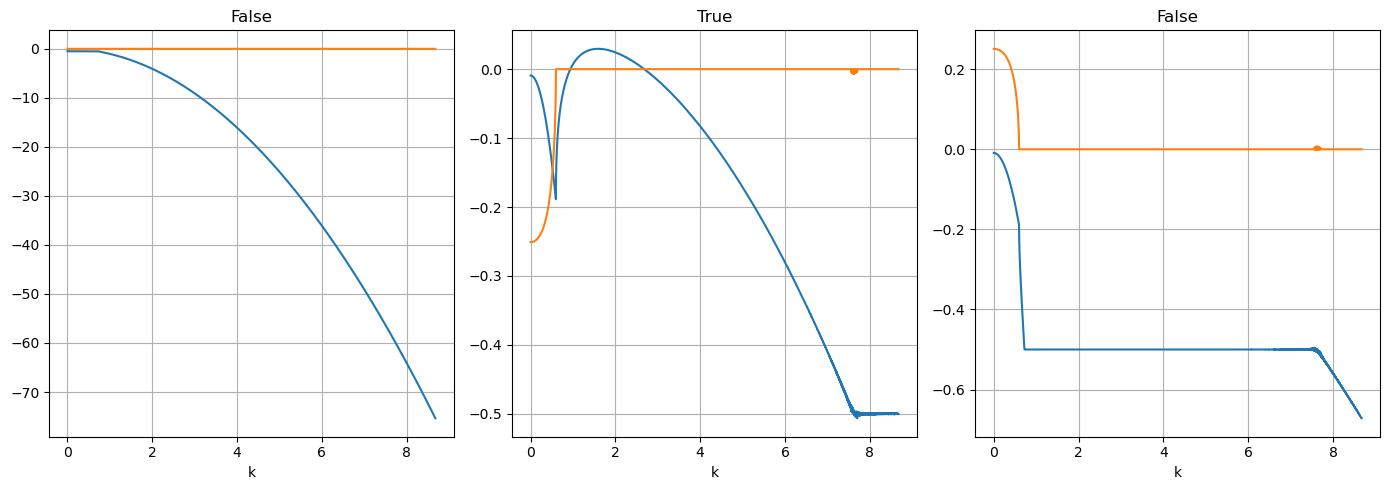

In [45]:
plot_dispersion(0)

In [46]:
turing_stationary_dispersions_1 = []
turing_stationary_dispersions_2 = []
turing_stationary_dispersions_3 = []
turing_stationary_parameters = []
turing_stationary_k_max = []

turing_hopf_dispersions_1 = []
turing_hopf_dispersions_2 = []
turing_hopf_dispersions_3 = []
turing_hopf_parameters = []
turing_hopf_k_max = []


def has_non_zero_imag(ar1, ar2, ar3):
    
    return ((np.count_nonzero(np.imag(ar1[(np.real(ar1) > 0)[0] ])) > 0)
            or 
            (np.count_nonzero(np.imag(ar3[(np.real(ar2) > 0)[0] ])) > 0)
            or
            (np.count_nonzero(np.imag(ar3[(np.real(ar3) > 0)[0] ])) > 0)
           )


for i in tqdm(range(len(turing_parameters))):
    
    dis1 = turing_dispersions_1[i]
    dis2 = turing_dispersions_2[i]
    dis3 = turing_dispersions_3[i]
                    
    if has_non_zero_imag(dis1, dis2, dis3):
        turing_hopf_dispersions_1.append(dis1)
        turing_hopf_dispersions_2.append(dis2)
        turing_hopf_dispersions_3.append(dis3)
        turing_hopf_parameters.append(turing_parameters[i])
        turing_hopf_k_max.append(turing_k_max[i])
    else:
        turing_stationary_dispersions_1.append(dis1)
        turing_stationary_dispersions_2.append(dis2)
        turing_stationary_dispersions_3.append(dis3)
        turing_stationary_parameters.append(turing_parameters[i])
        turing_stationary_k_max.append(turing_k_max[i])

100%|██████████| 87001/87001 [00:04<00:00, 19831.49it/s]


In [14]:
# with open('turing_stationary_parameters_set_2.npy', 'wb') as f:
#     np.save(f, turing_stationary_parameters)

# with open('turing_stationary_k_max_set_2.npy', 'wb') as f:
#     np.save(f, turing_stationary_k_max)



# ########################################################
# with open('turing_hopf_parameters_set_2.npy', 'wb') as f:
#     np.save(f, turing_hopf_parameters)

# with open('turing_hopf_k_max_set_2.npy', 'wb') as f:
#     np.save(f, turing_hopf_k_max)



with open('turing_stationary_parameters_set_2.npy', 'rb') as f:
    turing_stationary_parameters = np.load(f)

with open('turing_stationary_k_max_set_2.npy', 'rb') as f:
    turing_stationary_k_max = np.load(f)

with open('turing_hopf_parameters_set_2.npy', 'rb') as f:
    turing_hopf_parameters = np.load(f)
    
with open('turing_stationary_k_max_set_2.npy', 'rb') as f:
    turing_hopf_k_max = np.load(f)

In [16]:
np.set_printoptions(precision=3, suppress=True)

In [17]:
turing_stationary_parameters[144]  

array([  4.   ,   0.001,   0.1  ,  10.   ,   0.1  ,   0.5  ,  20.   ,
         0.1  ,   1.   ,  50.   ,   0.5  ,  10.   ,   0.5  ,   0.1  ,
        25.   , 100.   , 100.   ])

In [ ]:
[4.   ,   0.001,   0.1  ,  10.   ,   0.1  ,   0.5  ,  20.   ,
         0.1  ,   1.   ,  50.   ,   0.5  ,  10.   ,   0.5  ,   0.1  ,
        25.   , 100.   , 100. ]

In [47]:
len(turing_stationary_parameters)

86956

In [48]:
len(turing_hopf_parameters)

45

Parameters - 
n, 
             b_A, mu_A, V_A, K_AA, K_AB, K_AC,
             b_B, mu_B, V_B, K_BA, K_BC,
             b_C, mu_C, V_C, K_CB, K_CC
4.0
0.001 0.1 10.0 0.1 0.5 20.0
0.1 1.0 50.0 0.5 10.0
0.5 0.1 25.0 100.0 100.0
0.23116411699515435 2.284574442150446 5.0015601912347485


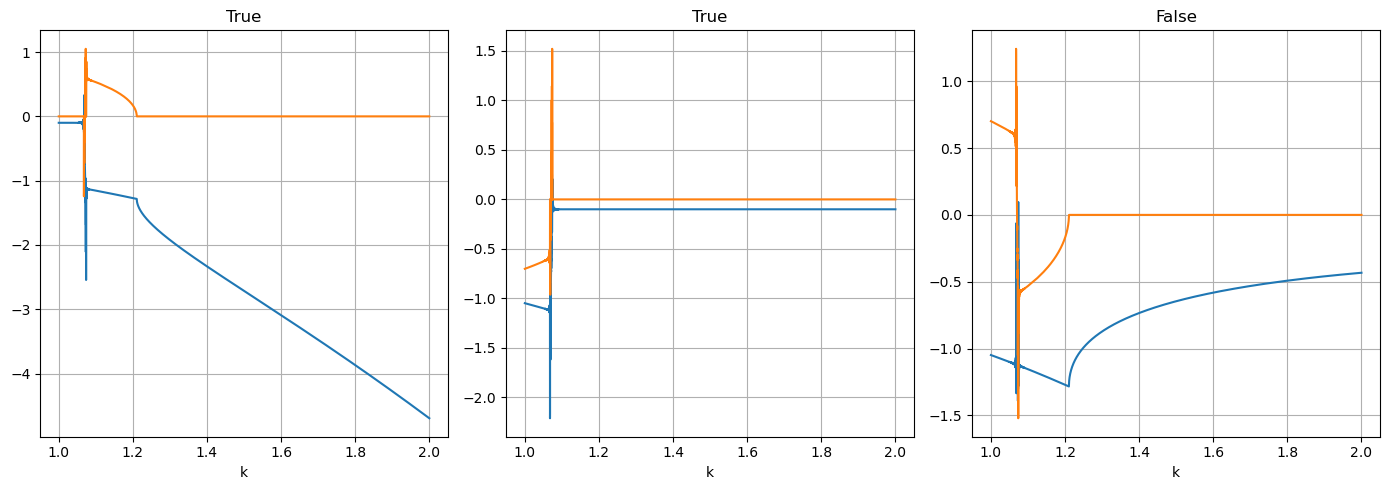

In [30]:
plot_dispersion(144, turing_stationary_parameters, turing_stationary_k_max,
                np.linspace(1, 2, 10000).astype(np.complex64))

Parameters - 
n, 
             b_A, mu_A, V_A, K_AA, K_AB, K_AC,
             b_B, mu_B, V_B, K_BA, K_BC,
             b_C, mu_C, V_C, K_CB, K_CC
4.0
5.0 25.0 25.0 0.5 1.0 0.5
0.1 0.5 10.0 5.0 10.0
0.001 0.1 5.0 1.0 5.0
k_max: 29.184084211904086
0.714751639161059 4.339421554816474 0.010000000147981806


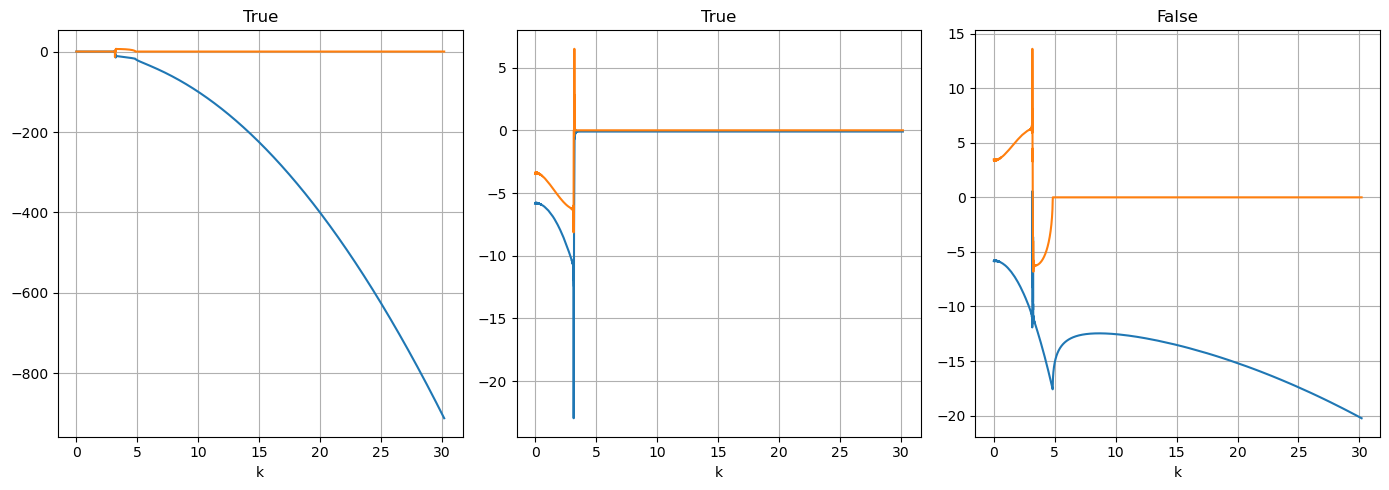

In [561]:
plot_dispersion(-1, turing_hopf_parameters)

# Important parameters

In [ ]:
4.0
0.001 0.1 5.0 0.5 5.0 25.0
0.001 0.5 10.0 10.0 25.0
1.0 0.1 5.0 25.0 25.0

4.0
0.001 0.1 5.0 0.5 5.0 25.0
0.001 0.5 10.0 10.0 25.0
1.0 0.1 5.0 25.0 25.0
7.388132430842352 15.503110247626704 12.69582581903488


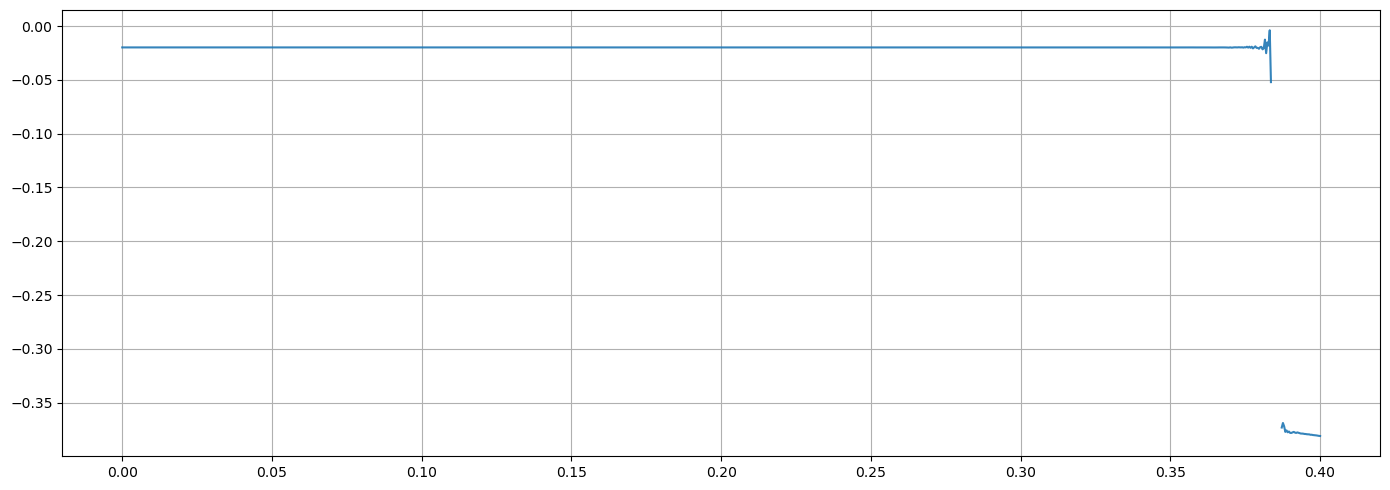

In [533]:
#index = 18
(n_val, 
b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = (4.0,
0.001, 0.1, 5.0, 0.5, 5.0, 25.0,
0.001, 0.5, 10.0, 10.0, 25.0,
1.0, 0.1, 5.0, 25.0, 25.0)
print(n_val)
print(b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val)
print(b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val)
print(b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val)
ks = np.linspace(0,.4, 1000).astype(np.complex64)
for dis1, dis2, dis3 in get_dispersions(ks, n_val, 
                    b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                    b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                    b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val):
    plt.figure(figsize=(14,5))
    #plt.subplot(131)
    #plt.title(f"{np.any(np.real(dis1) > 0)}")
    plt.plot(ks, np.real(dis1), alpha=.9)
    #plt.plot(ks, np.imag(dis1), alpha=.2)
    #plt.xlim([0,3])
    #plt.ylim([-.2, .2])
    plt.grid()
    #plt.subplot(132)
    #plt.title(f"{np.any(np.real(dis2) > 0)}")
    #plt.plot(ks, np.real(dis2), alpha=.2)
    #plt.plot(ks, np.imag(dis2), alpha=.2)
    #plt.xlim([0,3])
    #plt.ylim([-.2, .2])
    plt.grid()
    #plt.subplot(133)
    #plt.title(f"{np.any(np.real(dis3) > 0)}")
    #plt.plot(ks, np.real(dis3), alpha=.2)
    #plt.plot(ks, np.imag(dis3), alpha=.2)
    #plt.xlim([0,3])
    #plt.ylim([-.2, .2])
    plt.grid();plt.tight_layout();plt.show()
     

In [534]:
λ_1, λ_2, λ_3 = list(J_jac_diff.subs(
                                  {n:n_val, 
                                   b_A:b_A_val, 
                                   μ_A:mu_A_val, 
                                   V_A:V_A_val,
                                   K_AA:K_AA_val, 
                                   K_AB:K_AB_val,  
                                   K_AC:K_AC_val,
                                   b_B:b_B_val, 
                                   μ_B:mu_B_val, 
                                   V_B:V_B_val,
                                   K_BA:K_BA_val, 
                                   K_BC:K_BC_val,  
                                   b_C:b_C_val, 
                                   μ_C:mu_C_val, 
                                   V_C:V_C_val,
                                   K_CB:K_CB_val, 
                                   K_CC:K_CC_val,  
                                   A:roots[0], 
                                   B:roots[1], 
                                   C:roots[2],
                                   D_A:0.01,
                                   D_B:1.0}
                             ).eigenvals().keys())

λ_1_func = lambdify([k], 
                     λ_1,
                     modules='numpy')
λ_2_func = lambdify([k], 
                     λ_2,
                     modules='numpy')
λ_3_func = lambdify([k], 
                     λ_3,
                     modules='numpy')

In [535]:
ks = np.linspace(.38222,.39, 100).astype(np.complex64)

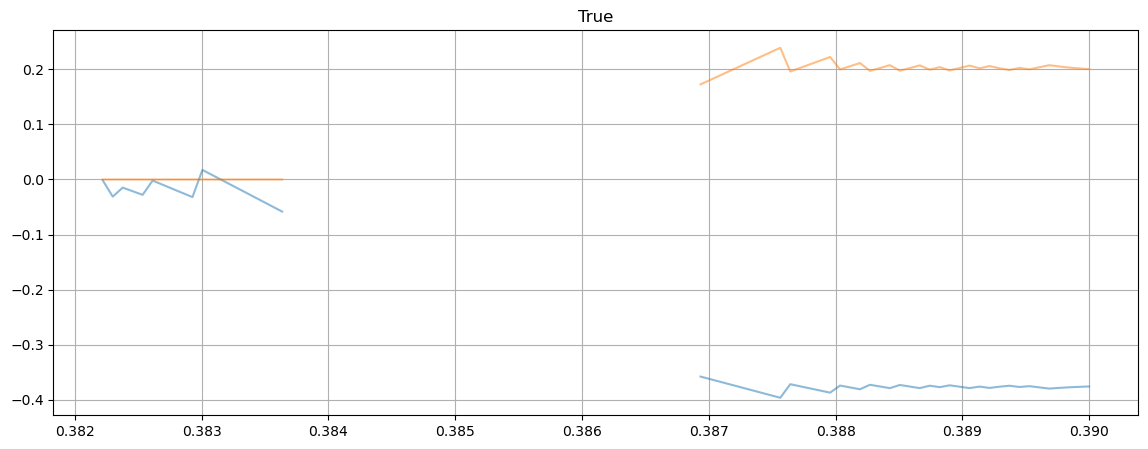

In [536]:
plt.figure(figsize=(14,5))
#plt.subplot(131)
plt.title(f"{np.any(np.real(dis1) > 0)}")
plt.plot(ks, np.real(λ_1_func(ks)), alpha=.5)
plt.plot(ks, np.imag(λ_1_func(ks)), alpha=.5)
#plt.plot(ks, np.real(λ_2_func(ks)), alpha=.5)
#plt.plot(ks, np.real(λ_3_func(ks)), alpha=.5)
#plt.plot(ks, np.imag(dis1), alpha=.2)
#plt.xlim([0,3])
#plt.ylim([-.2, .2])
plt.grid()

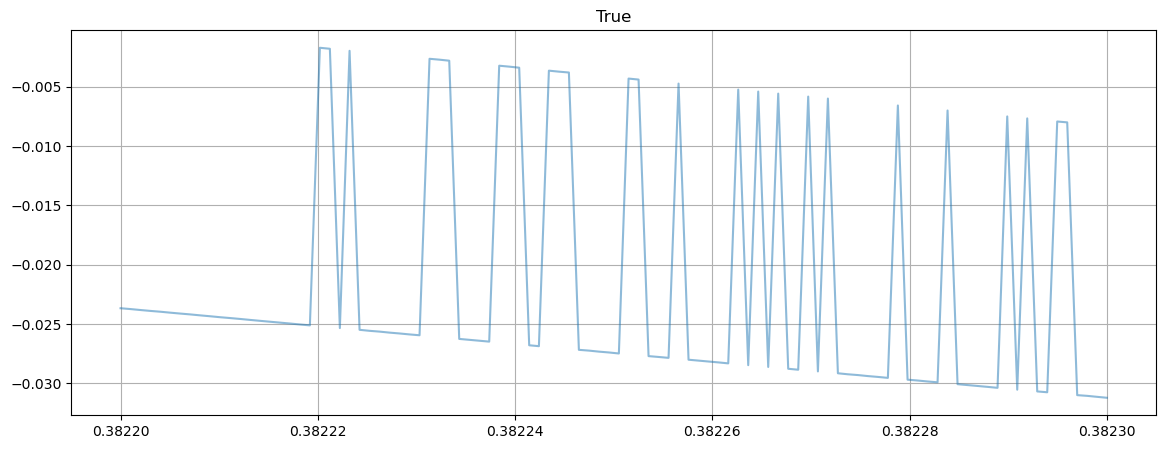

In [125]:
plt.figure(figsize=(14,5))
#plt.subplot(131)
plt.title(f"{np.any(np.real(dis1) > 0)}")
plt.plot(ks, np.real(λ_1_func(ks)), alpha=.5)
#plt.plot(ks, np.real(λ_2_func(ks)), alpha=.5)
#plt.plot(ks, np.real(λ_3_func(ks)), alpha=.5)
#plt.plot(ks, np.imag(dis1), alpha=.2)
#plt.xlim([0,3])
#plt.ylim([-.2, .2])
plt.grid()

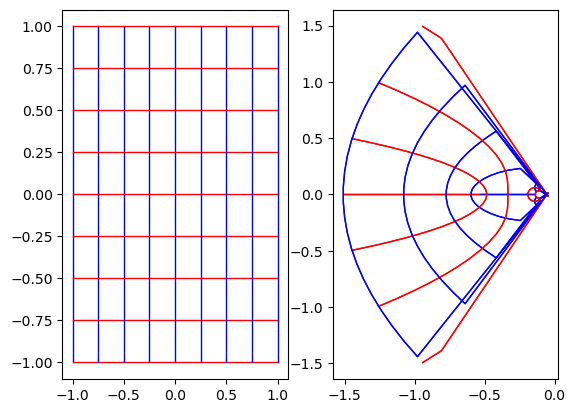

In [66]:
def plot_conformal_map(f, xmin, xmax, ymin, ymax, nb_grid, nb_points):
    xv, yv = np.meshgrid(np.linspace(xmin, xmax, nb_grid), np.linspace(ymin, ymax, nb_points))
    xv = np.transpose(xv)
    yv = np.transpose(yv)

    zv = f(xv + 1j*yv)
    uv = np.real(zv)
    vv = np.imag(zv)



    xh, yh = np.meshgrid(np.linspace(xmin, xmax, nb_points), np.linspace(ymin, ymax, nb_grid))

    zh = f(xh + 1j*yh)
    uh = np.real(zh)
    vh = np.imag(zh)


    ax = plt.subplot(121)
    for i in range(len(yv)):
        ax.plot(xv[i], yv[i], 'b-', lw=1)
        ax.plot(xh[i], yh[i], 'r-', lw=1)

    ax2 = plt.subplot(122)
    for i in range(len(vv)):
        ax2.plot(uv[i], vv[i], 'b-', lw=1)
        ax2.plot(uh[i], vh[i], 'r-', lw=1)

    plt.show()


nb_grid = 9
nb_points = 30

xmin, xmax, ymin, ymax = -1, 1, -1, 1

plot_conformal_map(λ_1_func, xmin, xmax, ymin, ymax, nb_grid, nb_points)

In [ ]:
def _lambdifygenerated(k):
    return -0.336666666666667*k**2 
- 0.33003300330033*(-0.03*k**4 - 0.376668508797078*k**2 + 1.0201*(k**2 + 0.614210455648221)**2 
- 0.536757685627948)/(0.00266788717409988*k**4 + 0.0278317781665336*k**2 
+ (k**2 + 0.614210455648221)**3 
- 0.485295073963822*(9.09*k**2 + 5.58317304184232)*(0.01*k**4 + 0.125556169599026*k**2 + 0.178919228542649) 
+ sqrt(-1.0*(-0.0294088814822076*k**4 - 0.369246651109771*k**2 + (k**2 + 0.614210455648221)**2 
- 0.52618143870988)**3 + (0.00266788717409988*k**4 + 0.0278317781665336*k**2 
+ (k**2 + 0.614210455648221)**3 
- 0.485295073963822*(9.09*k**2 + 5.58317304184232)*(0.01*k**4 + 0.125556169599026*k**2 + 0.178919228542649) 
                + 0.0434083635430563)**2) + 0.0434083635430563)**(1/3) 
- 0.336666666666667*(0.00266788717409988*k**4 + 0.0278317781665336*k**2 + 
(k**2 + 0.614210455648221)**3 
- 0.485295073963822*(9.09*k**2 + 5.58317304184232)*(0.01*k**4 + 0.125556169599026*k**2 + 0.178919228542649) 
+ sqrt(-1.0*(-0.0294088814822076*k**4 - 0.369246651109771*k**2 + (k**2 + 0.614210455648221)**2 - 0.52618143870988)**3 + (0.00266788717409988*k**4 + 0.0278317781665336*k**2 + (k**2 + 0.614210455648221)**3 - 0.485295073963822*(9.09*k**2 + 5.58317304184232)*(0.01*k**4 + 0.125556169599026*k**2 + 0.178919228542649) + 0.0434083635430563)**2) 
+ 0.0434083635430563)**(1/3) - 0.206784186734901

In [142]:
def _lambdifygenerated(k):
    return  - 0.336666666666667*(0.00266788717409988*k**4 + 0.0278317781665336*k**2 + (k**2 + 0.614210455648221)**3 - 0.485295073963822*(9.09*k**2 + 5.58317304184232)*(0.01*k**4 + 0.125556169599026*k**2 + 0.178919228542649) 
    +  


In [153]:
a1 = lambda kk: np.sqrt(-1.0*(-0.0294088814822076*kk**4 - 0.369246651109771*kk**2 + (kk**2 + 0.614210455648221)**2 - 0.52618143870988)**3 + (0.00266788717409988*kk**4 + 0.0278317781665336*kk**2 + (kk**2 + 0.614210455648221)**3 - 0.485295073963822*(9.09*kk**2 + 5.58317304184232)*(0.01*kk**4 + 0.125556169599026*kk**2 + 0.178919228542649) + 0.0434083635430563)**2)

In [157]:
a2 = lambda kk:(0.00266788717409988*kk**4 + 0.0278317781665336*kk**2 + (kk**2 + 0.614210455648221)**3 - 0.485295073963822*(9.09*kk**2 + 5.58317304184232)*(0.01*kk**4 + 0.125556169599026*kk**2 + 0.178919228542649) + np.sqrt(-1.0*(-0.0294088814822076*kk**4 - 0.369246651109771*kk**2 + (kk**2 + 0.614210455648221)**2 - 0.52618143870988)**3 + (0.00266788717409988*kk**4 + 0.0278317781665336*kk**2 + (kk**2 + 0.614210455648221)**3 - 0.485295073963822*(9.09*kk**2 + 5.58317304184232)*(0.01*kk**4 + 0.125556169599026*kk**2 + 0.178919228542649) + 0.0434083635430563)**2) + 0.0434083635430563)**(1/3)

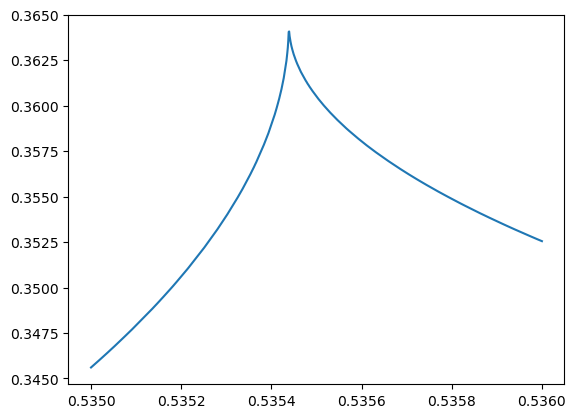

In [178]:
#ks = np.linspace(.38222,.38224, 100).astype(np.complex64)
ks = np.linspace(.535,.536, 1000).astype(np.complex64)
#plt.plot(ks, np.real(a2(ks)))
plt.plot(ks, np.imag(a2(ks)))

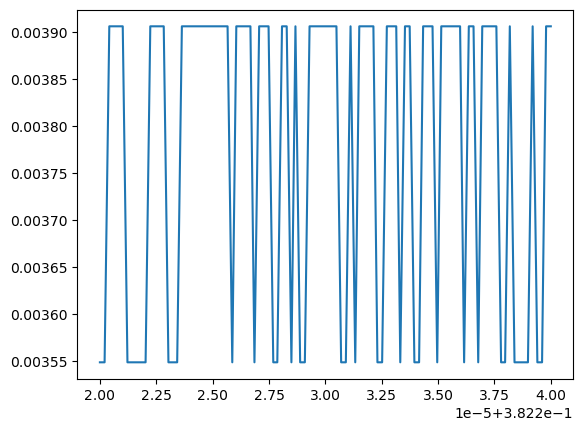

In [188]:
ks = np.linspace(.38222,.38224, 100).astype(np.complex64)
#ks = np.linspace(.535,.536, 1000).astype(np.complex64)
plt.plot(ks, np.real(a2(ks)))
#plt.plot(ks, np.imag(a2(ks)))

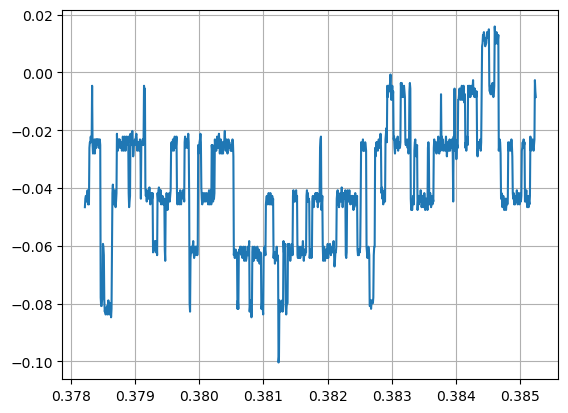

In [329]:
ks = np.linspace(.37822,.38524, 1000).astype(np.complex64)
#ks = np.linspace(0.1,1, 1000).astype(np.complex64)
#plt.plot(ks, np.real(λ_1_func(ks)))
plt.plot(ks, np.real(λ_1_func(ks + 80*np.pi*1j)))
#plt.plot(ks, np.real(λ_2_func(ks)))
#plt.plot(ks, np.real(λ_2_func(ks + 2*np.pi*1j)))
#plt.plot(ks, np.real(λ_3_func(ks)))
#plt.plot(ks, np.real(λ_3_func(ks + 2*np.pi*1j)))
#plt.plot(ks, np.imag(λ_1_func(ks)))
#plt.plot(ks, np.real(λ_2_func(ks)))
#plt.plot(ks, np.real(λ_3_func(ks)))
plt.grid()

Parameters - 
n, 
             b_A, mu_A, V_A, K_AA, K_AB, K_AC,
             b_B, mu_B, V_B, K_BA, K_BC,
             b_C, mu_C, V_C, K_CB, K_CC
4.0
0.001 0.5 25.0 5.0 5.0 5.0
0.001 5.0 100.0 10.0 10.0
1.0 0.5 25.0 5.0 5.0
6.645983663271499 14.723677954396189 2.0595613145672935


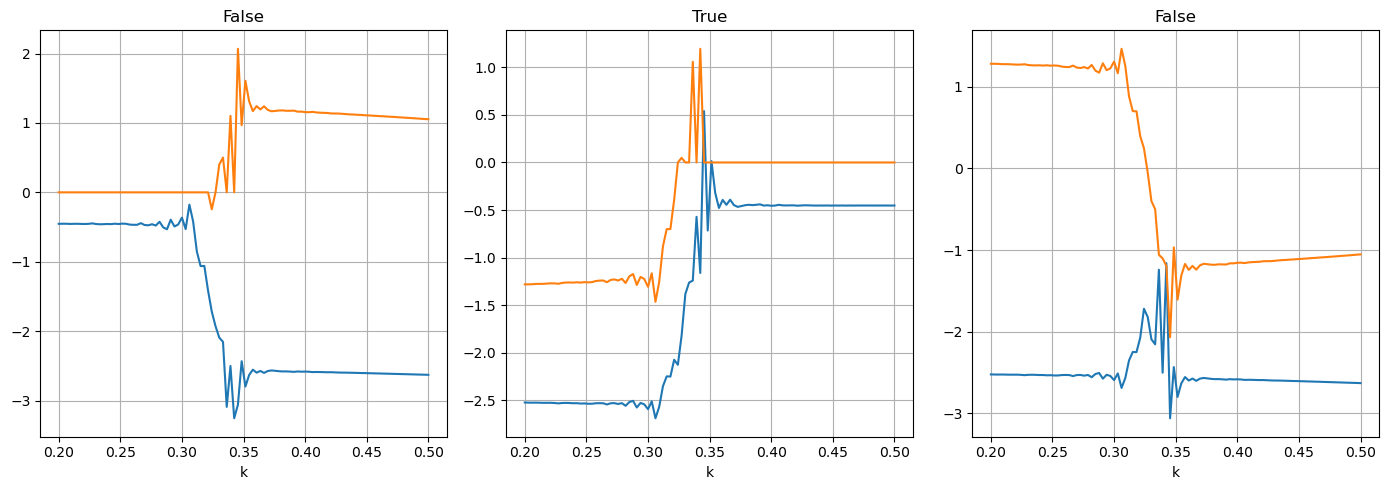

In [37]:
plot_dispersion(0, np.array([[4.0e+00, 1.0e-03, 5.0e-01, 2.5e+01, 5.0e+00, 5.0e+00, 5.0e+00,
       1.0e-03, 5.0e+00, 1.0e+02, 1.0e+01, 1.0e+01, 1.0e+00, 5.0e-01,
       2.5e+01, 5.0e+00, 5.0e+00]]),None, np.linspace(0.2,.5,100).astype(np.complex64))